# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [7]:
df= pd.read_csv('df7.csv', parse_dates=['Date'])
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df 
# len(df)

,ds,y,tby,ffr,fta,eps,div,une,vix
0,2005-06-20,1216.10,4.11,3.04,812235.0,84.81,1.76,5.0,148.30
1,2005-06-21,1213.61,4.06,3.04,812235.0,84.81,1.76,5.0,149.00
2,2005-06-22,1213.88,3.95,3.04,811179.0,84.81,1.76,5.0,148.40
3,2005-06-23,1200.73,3.96,3.04,811179.0,84.81,1.76,5.0,150.50
4,2005-06-24,1191.57,3.92,3.04,811179.0,84.81,1.76,5.0,152.00
...,...,...,...,...,...,...,...,...,...
3893,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,25.85
3894,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,25.30
3895,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,33.05
3896,2021-01-28,3787.38,1.07,0.09,7404926.0,95.72,1.58,6.3,30.49


In [8]:
df['div_une_vix'] = df['div'] * df['une'] * df['vix']

df = df.drop(columns=['ffr','div','une','vix'])

In [9]:
df

,ds,y,tby,fta,eps,div_une_vix
0,2005-06-20,1216.10,4.11,812235.0,84.81,1305.04000
1,2005-06-21,1213.61,4.06,812235.0,84.81,1311.20000
2,2005-06-22,1213.88,3.95,811179.0,84.81,1305.92000
3,2005-06-23,1200.73,3.96,811179.0,84.81,1324.40000
4,2005-06-24,1191.57,3.92,811179.0,84.81,1337.60000
...,...,...,...,...,...,...
3893,2021-01-25,3855.36,1.05,7414942.0,95.72,257.31090
3894,2021-01-26,3849.62,1.05,7414942.0,95.72,251.83620
3895,2021-01-27,3750.77,1.04,7404926.0,95.72,328.97970
3896,2021-01-28,3787.38,1.07,7404926.0,95.72,303.49746


In [10]:
from datetime import datetime
p = 0.9
# Train around 90% of dataset 
cutoff = int((p*len(df)//100)*100)
df_train = df[:cutoff].copy()
df_test = df.drop(df_train.index).copy()

print(df_train, df_test)

             ds        y   tby        fta     eps  div_une_vix
0    2005-06-20  1216.10  4.11   812235.0   84.81    1305.0400
1    2005-06-21  1213.61  4.06   812235.0   84.81    1311.2000
2    2005-06-22  1213.88  3.95   811179.0   84.81    1305.9200
3    2005-06-23  1200.73  3.96   811179.0   84.81    1324.4000
4    2005-06-24  1191.57  3.92   811179.0   84.81    1337.6000
...         ...      ...   ...        ...     ...          ...
3495 2019-06-20  2954.18  2.01  3844016.0  139.61     113.0220
3496 2019-06-21  2950.46  2.07  3844016.0  139.61     116.1810
3497 2019-06-24  2945.35  2.02  3844016.0  139.61     114.3558
3498 2019-06-25  2917.38  2.00  3844016.0  139.61     117.1638
3499 2019-06-26  2913.78  2.05  3826817.0  139.61     116.1810

[3500 rows x 6 columns]              ds        y   tby        fta     eps  div_une_vix
3500 2019-06-27  2924.92  2.01  3826817.0  139.61    113.02200
3501 2019-06-28  2941.76  2.00  3826817.0  139.61    110.21400
3502 2019-07-01  2964.33  2.03

 Use prophet() to make predictions, we will split training as train_1 and train_2 with ratio 40% vs 60%, 
 train_1 will be used to fit prophet(), then predict on train_2.  Getting the predictions, feed the data into
 the Scenario 2 model, train again to get the parameters a,b,c,....

In [11]:
#prophet part 
from fbprophet import Prophet
start = 1000 # 1000 # the number of initial data for training 
pred_size =100 # predicted periods 
num_winds = int((df_train.shape[0]-start)/pred_size) #(4000-3000)/100 =30

pro_pred = []

# use accumulated data to predict the next pred_size data
for i in range(num_winds):
    tmp_train = df_train.iloc[: start+ i*pred_size].copy()
    
    fbp = Prophet(daily_seasonality=True)
    # fit close price using fbprophet model
    fbp.fit(tmp_train[['ds','y']])
    
    # predict pred_size futures and get the forecast price 
    fut = fbp.make_future_dataframe(periods = pred_size,)
    tmp_forecast = fbp.predict(fut) 
    
    # only require the forcast on test data of temporary training data
    pred = tmp_forecast[start+ i*pred_size:].yhat
    pro_pred.append(pred)
    

In [12]:
pro_pred

[1000    843.297510
 1001    856.104661
 1002    852.543561
 1003    832.175457
 1004    829.387909
            ...    
 1095    646.146808
 1096    643.108344
 1097    639.120987
 1098    634.852825
 1099    646.825493
 Name: yhat, Length: 100, dtype: float64,
 1100    1057.557525
 1101    1056.489569
 1102    1056.256304
 1103    1051.140526
 1104    1050.570645
            ...     
 1195    1075.234791
 1196    1078.011126
 1197    1076.818334
 1198    1075.066651
 1199    1072.741865
 Name: yhat, Length: 100, dtype: float64,
 1200    1189.913008
 1201    1187.962009
 1202    1189.605037
 1203    1194.314116
 1204    1196.617070
            ...     
 1295    1307.510030
 1296    1310.199571
 1297    1312.325702
 1298    1314.743812
 1299    1313.438237
 Name: yhat, Length: 100, dtype: float64,
 1300    1122.891480
 1301    1124.659361
 1302    1126.291339
 1303    1128.206756
 1304    1123.944392
            ...     
 1395    1184.929151
 1396    1187.265246
 1397    1196.099314
 13

In [32]:
flat_pro_pred = [item for l1 in pro_pred for item in l1]

In [33]:
df.columns

Index(['ds', 'y', 'tby', 'fta', 'eps', 'div_une_vix'], dtype='object')

In [34]:
possible_features = ['tby', 'fta', 'eps', 'div_une_vix']

In [16]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False, normalize=True, copy_X = True)
reg.fit(df_train[start:cutoff][possible_features], df_train[start:cutoff]['y'] - flat_pro_pred)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

In [17]:
coef = []
for i in range(len(possible_features)):
    coef.append(np.round(reg.coef_[i],5))

print(coef)

[74.89949, 3e-05, -2.09836, -0.23938]


In [18]:
# Forecast the Test Data
from fbprophet import Prophet
test_time = int((1-p)* len(df))
fbp = Prophet(daily_seasonality=True)
fbp.fit(df_train[['ds','y']])
fut = fbp.make_future_dataframe(periods = test_time,)
forecast = fbp.predict(fut)

pred_test = forecast[cutoff:cutoff+test_time].yhat
pred_test = pred_test.ravel()

In [19]:
len(pred_test)

389

In [20]:
pp_test = pred_test.copy() # predicted price on testing data 
pp_train = flat_pro_pred.copy() # predicted price on training data 
for i in range(len(possible_features)):
    pp_test += coef[i] * df_test[df_test.columns[i+2]][:test_time].ravel()
    pp_train += coef[i] * df_train[df_train.columns[i+2]][start:].ravel()


In [21]:
from sklearn.metrics import mean_squared_error as MSE
# MSE for test data
# Actual close price: df_test[:test_time].y 
# Predicted price by prophet: pred_test
# Predicted price by tuning 
mse1 = MSE(df_test[:test_time].y,pred_test) #
mse2 = MSE(df_test[:test_time].y, pp_test)
print(mse1,mse2)

67923.0178358458 61607.97389371774


In [22]:
# MSE for train data
mse3 = MSE(df_train[start:].y, flat_pro_pred)
mse4 = MSE(df_train[start:].y, pp_train)
print(mse3,mse4)

19362.380200429267 15682.119546516684


In [30]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-06-20,1205.545046,1130.807182,1285.449724,1205.545046,1205.545046,1.498478,1.498478,1.498478,3.666644,...,-1.396531,-1.396531,-1.396531,-0.771634,-0.771634,-0.771634,0.0,0.0,0.0,1207.043525
1,2005-06-21,1205.764486,1133.104406,1284.539541,1205.764486,1205.764486,2.724435,2.724435,2.724435,3.666644,...,1.121386,1.121386,1.121386,-2.063594,-2.063594,-2.063594,0.0,0.0,0.0,1208.488921
2,2005-06-22,1205.983925,1132.168623,1282.204793,1205.983925,1205.983925,0.645827,0.645827,0.645827,3.666644,...,0.271938,0.271938,0.271938,-3.292755,-3.292755,-3.292755,0.0,0.0,0.0,1206.629751
3,2005-06-23,1206.203364,1122.554793,1277.725389,1206.203364,1206.203364,-0.358395,-0.358395,-0.358395,3.666644,...,0.406925,0.406925,0.406925,-4.431964,-4.431964,-4.431964,0.0,0.0,0.0,1205.844969
4,2005-06-24,1206.422803,1126.991441,1280.991949,1206.422803,1206.422803,-1.276071,-1.276071,-1.276071,3.666644,...,0.512945,0.512945,0.512945,-5.455659,-5.455659,-5.455659,0.0,0.0,0.0,1205.146732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,2020-07-15,3214.263032,2981.147110,3519.077730,2987.160384,3494.242150,13.672695,13.672695,13.672695,3.666644,...,0.271938,0.271938,0.271938,9.734113,9.734113,9.734113,0.0,0.0,0.0,3227.935727
3885,2020-07-16,3214.974621,2983.287371,3540.248437,2986.008948,3496.133992,15.068219,15.068219,15.068219,3.666644,...,0.406925,0.406925,0.406925,10.994650,10.994650,10.994650,0.0,0.0,0.0,3230.042840
3886,2020-07-17,3215.686210,2986.352825,3525.139976,2984.686752,3497.888128,16.311245,16.311245,16.311245,3.666644,...,0.512945,0.512945,0.512945,12.131656,12.131656,12.131656,0.0,0.0,0.0,3231.997455
3887,2020-07-18,3216.397799,2973.431341,3524.680868,2983.381546,3499.411616,16.337364,16.337364,16.337364,3.666644,...,-0.458330,-0.458330,-0.458330,13.129050,13.129050,13.129050,0.0,0.0,0.0,3232.735163


In [126]:
train_pred_yhat = [np.nan for i in range(start)] + flat_pro_pred
train_pp_train = [np.nan for i in range(start)] + pp_train.tolist()



In [98]:
train_date = df_train[['ds']].to_numpy().ravel()
train_date

array(['2005-06-20T00:00:00.000000000', '2005-06-21T00:00:00.000000000',
       '2005-06-22T00:00:00.000000000', ...,
       '2019-06-24T00:00:00.000000000', '2019-06-25T00:00:00.000000000',
       '2019-06-26T00:00:00.000000000'], dtype='datetime64[ns]')

In [127]:
fc_train = pd.DataFrame(data={'ds':train_date,'fbsp':train_pred_yhat, 'imsp': train_pp_train})
fc_train

,ds,fbsp,imsp
0,2005-06-20,NaN,NaN
1,2005-06-21,NaN,NaN
2,2005-06-22,NaN,NaN
3,2005-06-23,NaN,NaN
4,2005-06-24,NaN,NaN
...,...,...,...
3495,2019-06-20,3003.562802,2949.424011
3496,2019-06-21,3003.682323,2953.281300
3497,2019-06-24,3003.385785,2949.676703
3498,2019-06-25,3002.756425,2946.877175


In [128]:
m = len(forecast) -cutoff
test_pred_yhat = forecast.loc[cutoff:].yhat.copy().to_numpy().ravel()
test_date = df_test[['ds']][:m].to_numpy().ravel()

In [129]:
fc_test = pd.DataFrame(data={'ds':test_date, 'fbsp':test_pred_yhat, 'imsp': pp_test.tolist() })
fc_test

,ds,fbsp,imsp
0,2019-06-27,2937.723019,2883.068258
1,2019-06-28,2938.085533,2883.353956
2,2019-07-01,2937.566307,2885.937765
3,2019-07-02,2938.221401,2883.984728
4,2019-07-03,2938.144561,2882.419286
...,...,...,...
384,2021-01-11,3227.935727,3275.238491
385,2021-01-12,3230.042840,3279.275663
386,2021-01-13,3231.997455,3279.342476
387,2021-01-14,3232.735163,3282.752904


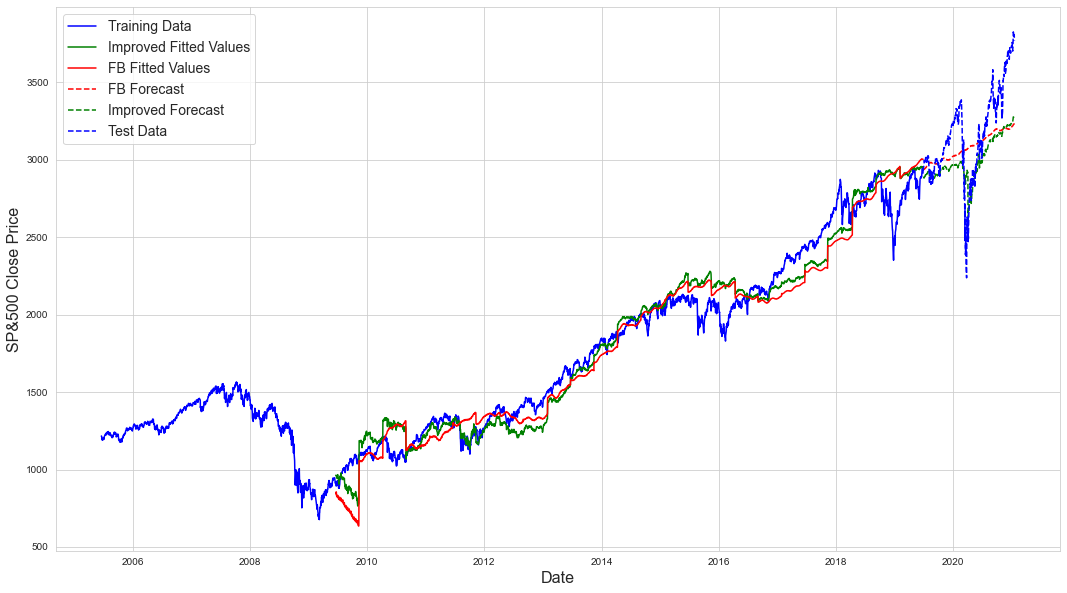

In [134]:
plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b',
            label = "Training Data")

plt.plot(df_train.ds, fc_train.imsp,'g-',
            label = "Improved Fitted Values")

# plot the fit
plt.plot(df_train.ds, fc_train.fbsp,'r-',
            label = "FB Fitted Values")

# # plot the forecast
plt.plot(df_test[:m].ds, fc_test.fbsp,'r--',
            label = "FB Forecast")
plt.plot(df_test[:m].ds, fc_test.imsp,'g--',
            label = "Improved Forecast")
plt.plot(df_test[:m].ds,df_test[:m].y,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()